In [ ]:
########################################################################################################################
# Filename: FF_Models_Training.ipynb
#
# Purpose: Multi-label Text-categorization via feed forward neural networks -- Train networks, tune hyperparameters
#          via grid search and aggregate results.
#
# Author(s): Bobby (Robert) Lumpkin
#
# Library Dependencies: numpy, pandas, math, scikit-learn, json, joblib, os, sys, threshold_learning, matplotlib,  
#                       ast, random, tensorflow, tensorflow_addons, bpmll, FFNN_gridSearch_aid
########################################################################################################################

# Multilabel Text Classification with Feed Forward Networks

In [169]:
import numpy as np
import pandas as pd
import math
import os
import json
import ast
import random
from joblib import dump, load
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from bpmll import bp_mll_loss
import sklearn_json as skljson
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import sys
os.chdir('C:\\Users\\rober\\OneDrive\\Documents\\Multilabel-Text-Classification\\Deep Learning Models\\FF Models')  ## Set working directory
                                                                                                                      ## to be 'ANN Results'
sys.path.append('../../ThresholdFunctionLearning')    ## Append path to the ThresholdFunctionLearning directory to the interpreters
                                                   ## search path
from threshold_learning import predict_test_labels_binary    ## Import the 'predict_test_labels_binary()' function from the 
from threshold_learning import predict_labels_binary         ## threshold_learning library
sys.path.append('GridSearchAid_FFNetworks')
from FFNN_gridSearch_aid import SizeLayersPows2, createModel
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [181]:
## Set config values
num_epochs = 30
activation_func = 'relu'
output_activation = 'sigmoid'
loss_func = 'binary_crossentropy'
num_layers_list = [3, 5, 7]
learning_rates_list = [0.1, 0.01, 0.001]
path_to_sepPCs_data = '../../Data/tfidf_PC_separable.npz'
path_to_encoded_data = '../../Data/tfidf_encoded_data.npz'
path_to_training_histories_cache = "Training Histories Layers_LR GS"
path_to_sepPC_models = 'Models sepPCs'
path_to_encoded_models = 'Models encoded'

In [123]:
## Load the seperabe PCs training and test data
npzfile = np.load(path_to_sepPCs_data)
X_sepPCs_train = npzfile['X_sepPCs_train']
X_sepPCs_test = npzfile['X_sepPCs_test']
Y_train = npzfile['Y_train'].astype('float64')
Y_test = npzfile['Y_test'].astype('float64')

## Load the autoencoder train/test features
npzfile = np.load(path_to_encoded_data)
encoded_train = npzfile['encoded_train']
encoded_test = npzfile['encoded_test']

## Load the tfidf training and test data
npzfile = np.load("../../Data/tfidf_trainTest_data.npz", allow_pickle = True)
X_tfidfTrain = npzfile['X_tfidfTrain']
X_tfidfTest = npzfile['X_tfidfTest']

# Cross Entropy Models -- Traditional ("Naive") Approach


## Training on Dimension-Reduced Separable PC Vectors

In [20]:
%%capture
## (CAUTION: THIS TAKES A WHILE TO RUN. INSTEAD, USE NEXT CELL TO READ IN TRAINING HISTORIES)
## Perform grid search over learning rate and model complexity
model_dict = {}
history_dict = {}
history_df_dict = {}
for learning_rate in learning_rates_list:
    for num_layers in num_layers_list:
        model = createModel(X_sepPCs_train, 
                            num_layers, 
                            X_sepPCs_train.shape[0], 
                            Y_train.shape[1], 
                            activation_func = activation_func, 
                            output_activation = output_activation, 
                            loss_func = loss_func,
                            learning_rate = learning_rate)
    
        tf.random.set_seed(123)
        model_history = model.fit(X_sepPCs_train, Y_train, epochs = num_epochs,
                                  validation_data = (X_sepPCs_test, Y_test), verbose = 0)
        name = f"model_{num_layers}_sepPCs_ce_{learning_rate}"
        name = name.replace('.', '')
        model_dict[name] = model
        history_dict[name] = model_history
        history_df_dict[name] = pd.DataFrame(model_history.history)
        history_name = name + 'history_df'
        exec(history_name + ' = pd.DataFrame(model_history.history)')

In [138]:
## (NOTE: IF RUNNING PREVIOUS CELL, SKIP THIS CELL) -- Load training histories
histories = np.load(path_to_training_histories_cache + "/history_ce_FF_sepPCs.npz", allow_pickle = True)
history_cols = ['loss', 'hamming_loss', 'val_loss', 'val_hamming_loss']
for learning_rate in learning_rates_list:
    for num_layers in num_layers_list:
        history_name = f"model_{num_layers}_sepPCs_ce_{learning_rate}" + 'history_df'
        history_name = history_name.replace('.', '')
        exec_string = f"{history_name} = histories['{history_name}']"
        exec(exec_string)
        exec_string2 = f"{history_name} = pd.DataFrame({history_name}, columns = history_cols)"
        exec(exec_string2)

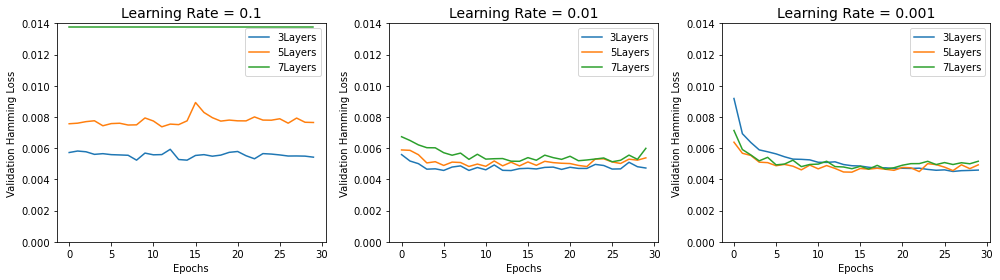

In [124]:
## Visualize the 'val_hamming_loss' histories for each model by learning rate
fig = plt.figure(figsize = (14, 4))
i = 1
for learning_rate in learning_rates_list:
    for num_layers in num_layers_list:
        history_name = f"model_{num_layers}_sepPCs_ce_{learning_rate}" + 'history_df'
        history_name = history_name.replace('.', '')
        val_loss_name = f"model_{num_layers}_val_hamming_loss"
        val_loss_name = val_loss_name.replace('.', '')
        exec(val_loss_name + ' = ' + history_name + '.val_hamming_loss')
        
    subplot_string = f"""ax{i} = fig.add_subplot(13{i})
ax{i}.plot(model_3_val_hamming_loss, label = str(3) + 'Layers')
ax{i}.plot(model_5_val_hamming_loss, label = str(5) + 'Layers')
ax{i}.plot(model_7_val_hamming_loss, label = str(7) + 'Layers')
ax{i}.set_ylim(0, 0.014)
ax{i}.set_xlabel('Epochs')
ax{i}.set_ylabel('Validation Hamming Loss')
ax{i}.legend()
ax{i}.set_title('Learning Rate = ' + str({learning_rate}), fontsize = 14)"""
    exec(subplot_string)
    i += 1
fig.tight_layout()

In [158]:
## Try applying a learned threshold function
#selected_model = model_dict['model_3_sepPCs_ce_001']    ## If ran training cell
selected_model = createModel(X_sepPCs_train,    ## If loading histories and model
                             3, 
                             X_sepPCs_train.shape[0], 
                             Y_train.shape[1], 
                             activation_func = activation_func, 
                             output_activation = output_activation, 
                             loss_func = loss_func,
                             learning_rate = 0.01)
selected_model.load_weights(path_to_sepPC_models + '/FFNN_best')

# Learn a threshold function
Y_train_pred_proba_array = selected_model.predict(X_sepPCs_train)
Y_test_pred_proba_array = selected_model.predict(X_sepPCs_test)

t_range = (0, 1)

#test_labels_binary, threshold_function = predict_test_labels_binary(Y_train_pred_proba_array, Y_train, Y_test_pred_proba_array, t_range)
threshold_function = load(path_to_sepPC_models + '/FFNN_best_thresholdFunction')
test_labels_binary = predict_labels_binary(Y_test_pred_proba_array, threshold_function)

sepPCs_ce_val_hamming_loss_withThreshold = metrics.hamming_loss(Y_test, test_labels_binary)
sepPCs_ce_val_hamming_loss_withThreshold

0.009502778697876413

In [148]:
## (CAUTION: DO NOT OVERWRITE EXISTING FILES) -- Write training histories to .npz file and save best model 
outfile = path_to_training_histories_cache + "/history_ce_FF_sepPCs.npz" 
save_string = 'np.savez_compressed(outfile'
for learning_rate in learning_rates_list:
    for num_layers in num_layers_list:
        history_name = f"model_{num_layers}_sepPCs_ce_{learning_rate}" + 'history_df'
        history_name = history_name.replace('.', '')
        save_string = save_string + f", \n {history_name} = {history_name}"
        
save_string = save_string + ')'   
#exec(save_string)

#selected_model = model_dict['model_3_sepPCs_ce_001']
#selected_model.save_weights(path_to_sepPC_models + '/FFNN_best')
#dump(threshold_function, path_to_sepPC_models + '/FFNN_best_thresholdFunction', compress = 3)

['Models sepPCs/FFNN_best_thresholdFunction']

## Training on Dimension-Reduced Autoencoder Feature Vectors

In [160]:
%%capture
## (CAUTION: THIS TAKES A WHILE TO RUN. INSTEAD, USE NEXT CELL TO READ IN TRAINING HISTORIES)
## Perform grid search over learning rate and model complexity
model_dict = {}
history_dict = {}
history_df_dict = {}
for learning_rate in learning_rates_list:
    for num_layers in num_layers_list:
        model = createModel(encoded_train, 
                            num_layers, 
                            encoded_train.shape[0], 
                            Y_train.shape[1], 
                            activation_func = activation_func, 
                            output_activation = output_activation, 
                            loss_func = loss_func,
                            learning_rate = learning_rate)
    
        tf.random.set_seed(123)
        model_history = model.fit(encoded_train, Y_train, epochs = num_epochs,
                                  validation_data = (encoded_test, Y_test), verbose = 0)
        name = f"model_{num_layers}_encoded_ce_{learning_rate}"
        name = name.replace('.', '')
        model_dict[name] = model
        history_dict[name] = model_history
        history_df_dict[name] = pd.DataFrame(model_history.history)
        history_name = name + 'history_df'
        exec(history_name + ' = pd.DataFrame(model_history.history)')

In [103]:
## (NOTE: IF RUNNING PREVIOUS CELL, SKIP THIS CELL) -- Load training histories
histories = np.load(path_to_training_histories_cache + "/history_ce_FF_encoded.npz", allow_pickle = True)
history_cols = ['loss', 'hamming_loss', 'val_loss', 'val_hamming_loss']
for learning_rate in learning_rates_list:
    for num_layers in num_layers_list:
        history_name = f"model_{num_layers}_encoded_ce_{learning_rate}" + 'history_df'
        history_name = history_name.replace('.', '')
        exec_string = f"{history_name} = histories['{history_name}']"
        exec(exec_string)
        exec_string2 = f"{history_name} = pd.DataFrame({history_name}, columns = history_cols)"
        exec(exec_string2)

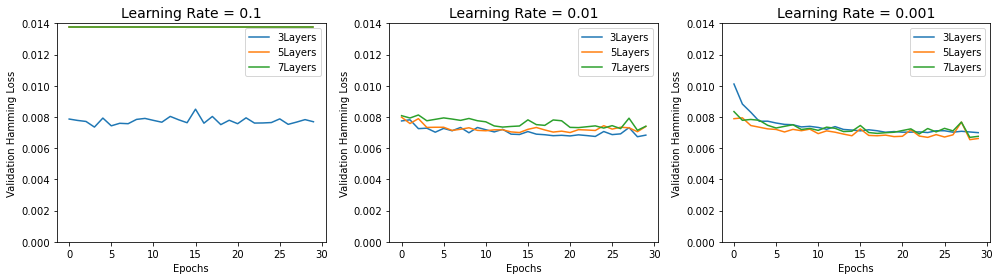

In [164]:
## Visualize the 'val_hamming_loss' histories for each model by learning rate
fig = plt.figure(figsize = (14, 4))
i = 1
for learning_rate in learning_rates_list:
    for num_layers in num_layers_list:
        history_name = f"model_{num_layers}_encoded_ce_{learning_rate}" + 'history_df'
        history_name = history_name.replace('.', '')
        val_loss_name = f"model_{num_layers}_val_hamming_loss"
        val_loss_name = val_loss_name.replace('.', '')
        exec(val_loss_name + ' = ' + history_name + '.val_hamming_loss')
        
    subplot_string = f"""ax{i} = fig.add_subplot(13{i})
ax{i}.plot(model_3_val_hamming_loss, label = str(3) + 'Layers')
ax{i}.plot(model_5_val_hamming_loss, label = str(5) + 'Layers')
ax{i}.plot(model_7_val_hamming_loss, label = str(7) + 'Layers')
ax{i}.set_ylim(0, 0.014)
ax{i}.set_xlabel('Epochs')
ax{i}.set_ylabel('Validation Hamming Loss')
ax{i}.legend()
ax{i}.set_title('Learning Rate = ' + str({learning_rate}), fontsize = 14)"""
    exec(subplot_string)
    i += 1
fig.tight_layout()

In [179]:
## Try applying a learned threshold function
#selected_model = model_dict['model_3_encoded_ce_001']    ## If ran training cell
selected_model = createModel(encoded_train,    ## If loading histories and model
                             3, 
                             encoded_train.shape[0], 
                             Y_train.shape[1], 
                             activation_func = activation_func, 
                             output_activation = output_activation, 
                             loss_func = loss_func,
                             learning_rate = 0.01)
selected_model.load_weights(path_to_encoded_models + '/FFNN_best')

# Learn a threshold function
Y_train_pred_proba_array = selected_model.predict(encoded_train)
Y_test_pred_proba_array = selected_model.predict(encoded_test)

t_range = (0, 1)

#test_labels_binary, threshold_function = predict_test_labels_binary(Y_train_pred_proba_array, Y_train, Y_test_pred_proba_array, t_range)
threshold_function = load(path_to_encoded_models + '/FFNN_best_thresholdFunction')
test_labels_binary = predict_labels_binary(Y_test_pred_proba_array, threshold_function)

encoded_ce_val_hamming_loss_withThreshold = metrics.hamming_loss(Y_test, test_labels_binary)
encoded_ce_val_hamming_loss_withThreshold

0.008976482278900298

In [166]:
## (CAUTION: DO NOT OVERWRITE EXISTING FILES) -- Write training histories to .npz file and save best model
outfile = path_to_training_histories_cache + "/history_ce_FF_encoded.npz" 
save_string = 'np.savez_compressed(outfile'
for learning_rate in learning_rates_list:
    for num_layers in num_layers_list:
        history_name = f"model_{num_layers}_encoded_ce_{learning_rate}" + 'history_df'
        history_name = history_name.replace('.', '')
        save_string = save_string + f", \n {history_name} = {history_name}"
        
save_string = save_string + ')'   
#exec(save_string)

selected_model = model_dict['model_3_encoded_ce_001']
selected_model.save_weights(path_to_encoded_models + '/FFNN_best')
#dump(threshold_function, path_to_encoded_models + '/FFNN_best_thresholdFunction', compress = 3)

['Models encoded/FFNN_best_thresholdFunction']

# BPMLL Models -- "Novel" Approach

## Training on Dimension-Reduced Separable PC Vectors

In [106]:
%%capture
## (CAUTION: THIS TAKES A WHILE TO RUN. INSTEAD, USE NEXT CELL TO READ IN TRAINING HISTORIES)
## Perform grid search over learning rate and model complexity
model_dict = {}
history_dict = {}
history_df_dict = {}
for learning_rate in learning_rates_list:
    for num_layers in num_layers_list:
        model = createModel(X_sepPCs_train, 
                            num_layers, 
                            X_sepPCs_train.shape[0], 
                            Y_train.shape[1], 
                            activation_func = activation_func, 
                            output_activation = output_activation, 
                            loss_func = bp_mll_loss,
                            learning_rate = learning_rate)
    
        tf.random.set_seed(123)
        model_history = model.fit(X_sepPCs_train, Y_train, epochs = num_epochs,
                                  validation_data = (X_sepPCs_test, Y_test), verbose = 0)
        name = f"model_{num_layers}_sepPCs_bpmll_{learning_rate}"
        name = name.replace('.', '')
        model_dict[name] = model
        history_dict[name] = model_history
        history_df_dict[name] = pd.DataFrame(model_history.history)
        history_name = name + 'history_df'
        exec(history_name + ' = pd.DataFrame(model_history.history)')

In [114]:
## (NOTE: IF RUNNING PREVIOUS CELL, SKIP THIS CELL) -- Load training histories
histories = np.load(path_to_training_histories_cache + "/history_bpmll_FF_sepPCs.npz", allow_pickle = True)
history_cols = ['loss', 'hamming_loss', 'val_loss', 'val_hamming_loss']
for learning_rate in learning_rates_list:
    for num_layers in num_layers_list:
        history_name = f"model_{num_layers}_sepPCs_bpmll_{learning_rate}" + 'history_df'
        history_name = history_name.replace('.', '')
        exec_string = f"{history_name} = histories['{history_name}']"
        exec(exec_string)
        exec_string2 = f"{history_name} = pd.DataFrame({history_name}, columns = history_cols)"
        exec(exec_string2)

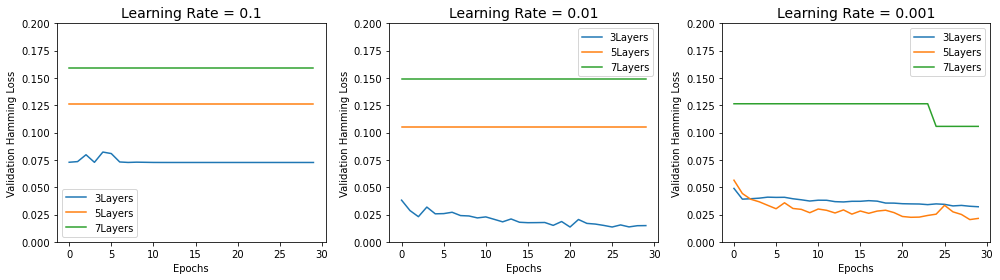

In [115]:
## Visualize the 'val_hamming_loss' histories for each model by learning rate
fig = plt.figure(figsize = (14, 4))
i = 1
for learning_rate in learning_rates_list:
    for num_layers in num_layers_list:
        history_name = f"model_{num_layers}_sepPCs_bpmll_{learning_rate}" + 'history_df'
        history_name = history_name.replace('.', '')
        val_loss_name = f"model_{num_layers}_val_hamming_loss"
        val_loss_name = val_loss_name.replace('.', '')
        exec(val_loss_name + ' = ' + history_name + '.val_hamming_loss')
        
    subplot_string = f"""ax{i} = fig.add_subplot(13{i})
ax{i}.plot(model_3_val_hamming_loss, label = str(3) + 'Layers')
ax{i}.plot(model_5_val_hamming_loss, label = str(5) + 'Layers')
ax{i}.plot(model_7_val_hamming_loss, label = str(7) + 'Layers')
ax{i}.set_ylim(0, 0.20)
ax{i}.set_xlabel('Epochs')
ax{i}.set_ylabel('Validation Hamming Loss')
ax{i}.legend()
ax{i}.set_title('Learning Rate = ' + str({learning_rate}), fontsize = 14)"""
    exec(subplot_string)
    i += 1
fig.tight_layout()

In [156]:
## Try applying a learned threshold function
#selected_model = model_dict['model_3_sepPCs_ce_001']    ## If ran training cell
selected_model = createModel(X_sepPCs_train,    ## If loading histories and model
                             3, 
                             X_sepPCs_train.shape[0], 
                             Y_train.shape[1], 
                             activation_func = activation_func, 
                             output_activation = output_activation, 
                             loss_func = bp_mll_loss,
                             learning_rate = 0.01)
selected_model.load_weights(path_to_sepPC_models + '/FFNN_best_bpmll')

# Learn a threshold function
Y_train_pred_proba_array = selected_model.predict(X_sepPCs_train)
Y_test_pred_proba_array = selected_model.predict(X_sepPCs_test)

t_range = (0, 1)

#test_labels_binary, threshold_function = predict_test_labels_binary(Y_train_pred_proba_array, Y_train, Y_test_pred_proba_array, t_range)
threshold_function = load(path_to_sepPC_models + '/FFNN_best_bpmll_thresholdFunction')
test_labels_binary = predict_labels_binary(Y_test_pred_proba_array, threshold_function)

sepPCs_bpmll_val_hamming_loss_withThreshold = metrics.hamming_loss(Y_test, test_labels_binary)
sepPCs_bpmll_val_hamming_loss_withThreshold

0.02497147694232822

In [154]:
## (CAUTION: DO NOT OVERWRITE EXISTING FILES) -- Write training histories to .npz file and save best model
outfile = path_to_training_histories_cache + "/history_bpmll_FF_sepPCs.npz" 
save_string = 'np.savez_compressed(outfile'
for learning_rate in learning_rates_list:
    for num_layers in num_layers_list:
        history_name = f"model_{num_layers}_sepPCs_bpmll_{learning_rate}" + 'history_df'
        history_name = history_name.replace('.', '')
        save_string = save_string + f", \n {history_name} = {history_name}"
        
save_string = save_string + ')'   
#exec(save_string)

#selected_model = model_dict['model_3_sepPCs_bpmll_001']
#selected_model.save_weights(path_to_sepPC_models + '/FFNN_best_bpmll')
#dump(threshold_function, path_to_sepPC_models + '/FFNN_best_bpmll_thresholdFunction', compress = 3)

['Models sepPCs/FFNN_best_bpmll_thresholdFunction']

## Training on Dimension-Reduced Autoencoder Feature Vectors

In [170]:
%%capture
## (CAUTION: THIS TAKES A WHILE TO RUN. INSTEAD, USE NEXT CELL TO READ IN TRAINING HISTORIES)
## Perform grid search over learning rate and model complexity
model_dict = {}
history_dict = {}
history_df_dict = {}
for learning_rate in learning_rates_list:
    for num_layers in num_layers_list:
        model = createModel(encoded_train, 
                            num_layers, 
                            encoded_train.shape[0], 
                            Y_train.shape[1], 
                            activation_func = activation_func, 
                            output_activation = output_activation, 
                            loss_func = bp_mll_loss,
                            learning_rate = learning_rate)
    
        tf.random.set_seed(123)
        model_history = model.fit(encoded_train, Y_train, epochs = num_epochs,
                                  validation_data = (encoded_test, Y_test), verbose = 0)
        name = f"model_{num_layers}_encoded_bpmll_{learning_rate}"
        name = name.replace('.', '')
        model_dict[name] = model
        history_dict[name] = model_history
        history_df_dict[name] = pd.DataFrame(model_history.history)
        history_name = name + 'history_df'
        exec(history_name + ' = pd.DataFrame(model_history.history)')

In [120]:
## (NOTE: IF RUNNING PREVIOUS CELL, SKIP THIS CELL) -- Load training histories
histories = np.load(path_to_training_histories_cache + "/history_bpmll_FF_encoded.npz", allow_pickle = True)
history_cols = ['loss', 'hamming_loss', 'val_loss', 'val_hamming_loss']
for learning_rate in learning_rates_list:
    for num_layers in num_layers_list:
        history_name = f"model_{num_layers}_encoded_bpmll_{learning_rate}" + 'history_df'
        history_name = history_name.replace('.', '')
        exec_string = f"{history_name} = histories['{history_name}']"
        exec(exec_string)
        exec_string2 = f"{history_name} = pd.DataFrame({history_name}, columns = history_cols)"
        exec(exec_string2)

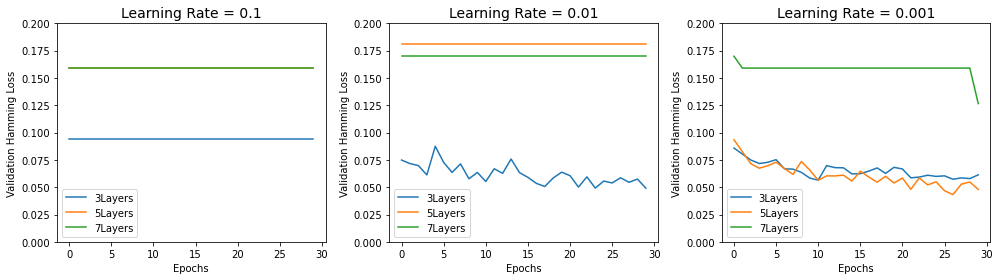

In [171]:
## Visualize the 'val_hamming_loss' histories for each model by learning rate
fig = plt.figure(figsize = (14, 4))
i = 1
for learning_rate in learning_rates_list:
    for num_layers in num_layers_list:
        history_name = f"model_{num_layers}_encoded_bpmll_{learning_rate}" + 'history_df'
        history_name = history_name.replace('.', '')
        val_loss_name = f"model_{num_layers}_val_hamming_loss"
        val_loss_name = val_loss_name.replace('.', '')
        exec(val_loss_name + ' = ' + history_name + '.val_hamming_loss')
        
    subplot_string = f"""ax{i} = fig.add_subplot(13{i})
ax{i}.plot(model_3_val_hamming_loss, label = str(3) + 'Layers')
ax{i}.plot(model_5_val_hamming_loss, label = str(5) + 'Layers')
ax{i}.plot(model_7_val_hamming_loss, label = str(7) + 'Layers')
ax{i}.set_ylim(0, 0.20)
ax{i}.set_xlabel('Epochs')
ax{i}.set_ylabel('Validation Hamming Loss')
ax{i}.legend()
ax{i}.set_title('Learning Rate = ' + str({learning_rate}), fontsize = 14)"""
    exec(subplot_string)
    i += 1
fig.tight_layout()

In [178]:
## Try applying a learned threshold function
#selected_model = model_dict['model_3_encoded_ce_001']    ## If ran training cell
selected_model = createModel(encoded_train,    ## If loading histories and model
                             3, 
                             encoded_train.shape[0], 
                             Y_train.shape[1], 
                             activation_func = activation_func, 
                             output_activation = output_activation, 
                             loss_func = bp_mll_loss,
                             learning_rate = 0.01)
selected_model.load_weights(path_to_encoded_models + '/FFNN_best_bpmll')

# Learn a threshold function
Y_train_pred_proba_array = selected_model.predict(encoded_train)
Y_test_pred_proba_array = selected_model.predict(encoded_test)

t_range = (0, 1)

#test_labels_binary, threshold_function = predict_test_labels_binary(Y_train_pred_proba_array, Y_train, Y_test_pred_proba_array, t_range)
threshold_function = load(path_to_encoded_models + '/FFNN_best_bpmll_thresholdFunction')
test_labels_binary = predict_labels_binary(Y_test_pred_proba_array, threshold_function)

encoded_bpmll_val_hamming_loss_withThreshold = metrics.hamming_loss(Y_test, test_labels_binary)
encoded_bpmll_val_hamming_loss_withThreshold

0.0245151080195797

In [175]:
## (CAUTION: DO NOT OVERWRITE EXISTING FILES) -- Write training histories to .npz file and save best model 
outfile = path_to_training_histories_cache + "/history_bpmll_FF_encoded.npz" 
save_string = 'np.savez_compressed(outfile'
for learning_rate in learning_rates_list:
    for num_layers in num_layers_list:
        history_name = f"model_{num_layers}_encoded_bpmll_{learning_rate}" + 'history_df'
        history_name = history_name.replace('.', '')
        save_string = save_string + f", \n {history_name} = {history_name}"
        
save_string = save_string + ')'   
#exec(save_string)

#selected_model = model_dict['model_3_encoded_bpmll_001']
#selected_model.save_weights(path_to_encoded_models + '/FFNN_best_bpmll')
#dump(threshold_function, path_to_encoded_models + '/FFNN_best_bpmll_thresholdFunction', compress = 3)

['Models encoded/FFNN_best_bpmll_thresholdFunction']

## Results

In [180]:
## Display val hamming loss results for best models
sepPCs_ce_val_hamming_loss = model_3_sepPCs_ce_001history_df.val_hamming_loss[num_epochs - 1]
encoded_ce_val_hamming_loss = model_3_encoded_ce_001history_df.val_hamming_loss[num_epochs - 1]
sepPCs_bpmll_val_hamming_loss = model_3_sepPCs_bpmll_001history_df.val_hamming_loss[num_epochs - 1]
encoded_bpmll_val_hamming_loss = model_3_encoded_bpmll_001history_df.val_hamming_loss[num_epochs - 1]

results_df = pd.DataFrame({'PCA' : [sepPCs_ce_val_hamming_loss, 
                                    sepPCs_ce_val_hamming_loss_withThreshold, 
                                    sepPCs_bpmll_val_hamming_loss, 
                                    sepPCs_bpmll_val_hamming_loss_withThreshold],
                           'Autoencoder' : [encoded_ce_val_hamming_loss, 
                                            encoded_ce_val_hamming_loss_withThreshold,
                                            encoded_bpmll_val_hamming_loss,
                                            encoded_bpmll_val_hamming_loss_withThreshold]},
                           index = ['CE Constant Threshold', 
                                    'CE Learned Threshold',
                                    'BPMLL Constant Threshold',
                                    'BPMLL Learned Threshold'])
display(results_df)

,PCA,Autoencoder
CE Constant Threshold,0.004729,0.006838
CE Learned Threshold,0.009503,0.008976
BPMLL Constant Threshold,0.014836,0.049074
BPMLL Learned Threshold,0.024971,0.024515
